# Introduction
This project predict whether it will rain in australia based on historical weather data using logisitc regression

# Dataset Context
This Dataset sourced from kaggle contain about 10 years of daily weather observations for numerous australian weather stations.

Rain tomorrow is the variable to predict. Meaning did it rain the next day - Yes or No?

In [3]:
# Importing the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression # For logistic regression model
from sklearn.preprocessing import StandardScaler # For feature standardization
from sklearn.model_selection import train_test_split # For splitting data into training and testing sets
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # For model evaluation
from sklearn.impute import SimpleImputer # For handling missing values

In [4]:
# Importing the dataset
data = pd.read_csv('weatherAUS.csv')

In [6]:
data.shape

(145460, 23)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [11]:
# Identifying column with missing values
miss_values = data.columns[data.isnull().any()]

In [15]:
# Handling the missing values
for column in miss_values:
  # If column is numerical compute the mean
  if data[column].dtype == 'float64':
    imputer = SimpleImputer(strategy= 'mean')
    data[column] = imputer.fit_transform(data[[column]])
  # If categorical compute the mode
  else:
    imputer = SimpleImputer(strategy= 'most_frequent')
    data[column] = imputer.fit_transform(data[[column]])

# Verify that all missing values have been handled
print(data.isnull().sum())

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


# Exploratory Data Analysis

In [16]:
data['RainTomorrow'].value_counts()

No     113583
Yes     31877
Name: RainTomorrow, dtype: int64

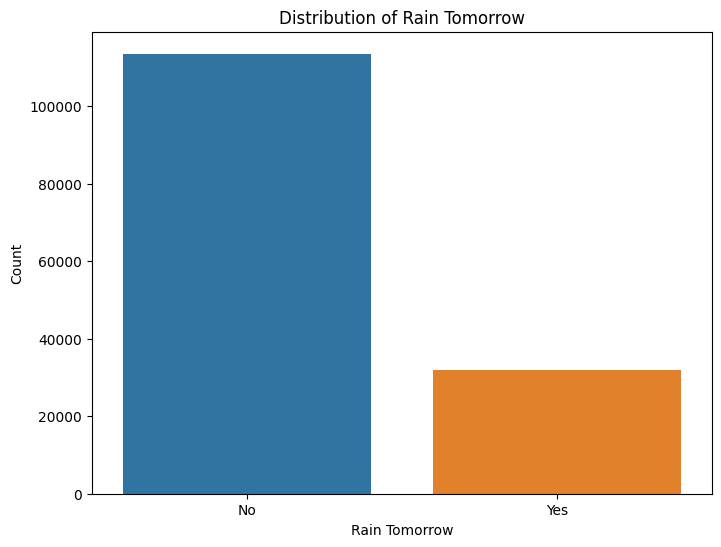

In [20]:
# Visualize distribution of target variable
plt.figure(figsize = (8,6))
sns.countplot(data=data, x='RainTomorrow')
plt.xlabel('Rain Tomorrow')
plt.ylabel('Count')
plt.title('Distribution of Rain Tomorrow')
plt.show()

In [21]:
data.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [22]:
# Summary Statistics of selected Numerical Features
num_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm']
data[num_features].describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,Humidity9am,Humidity3pm
count,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000
mean,12.194034,23.221348,2.360918,40.035230,68.880831,51.539116
std,6.365750,7.088124,8.382488,13.118253,18.854765,20.471189
min,-8.500000,-4.800000,0.000000,6.000000,0.000000,0.000000
25%,7.700000,18.000000,0.000000,31.000000,57.000000,37.000000
50%,12.100000,22.700000,0.000000,39.000000,69.000000,51.539116
75%,16.800000,28.200000,1.000000,46.000000,83.000000,65.000000
max,33.900000,48.100000,371.000000,135.000000,100.000000,100.000000


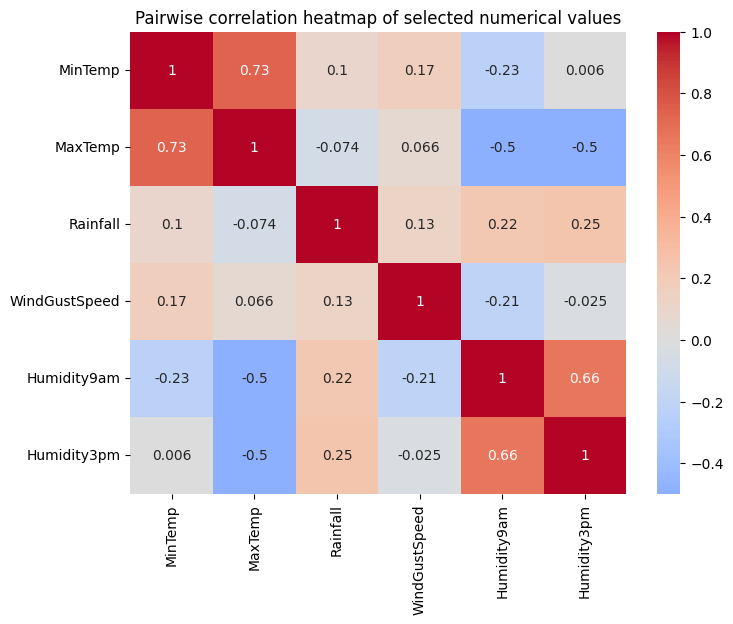

In [28]:
# Pairwise correlation heatmap of selected numerical values
plt.figure(figsize =(8,6))
sns.heatmap(data[num_features].corr(), annot = True, cmap='coolwarm', center = 0)
plt.title('Pairwise correlation heatmap of selected numerical values')
plt.show()

In [37]:
# Select Top 10 locations with highest counts
top10_location = data['Location'].value_counts().head(10).index

# Filter data frame for top location
top_location = data[data['Location'].isin(top10_location)]

<Figure size 1000x600 with 0 Axes>

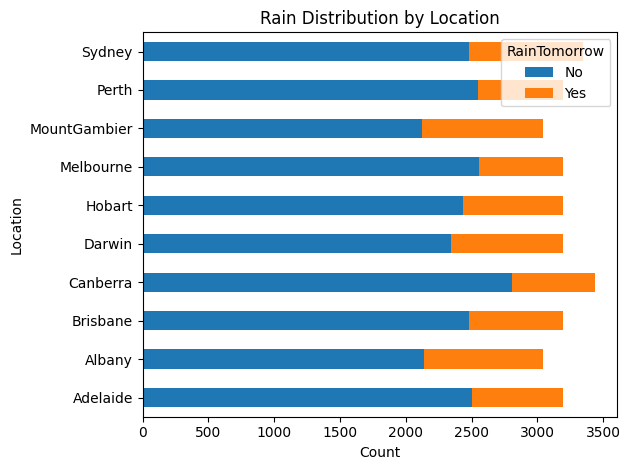

In [49]:
# Visualize the distribution of rain tomorrow accross location
# size() is used to calculate the size count of each and .unstack() is used to pivot series into dataframe
plt.figure(figsize =(10,6))
location_distribution = top_location.groupby(['Location', 'RainTomorrow']).size().unstack()
location_distribution.plot(kind = 'barh', stacked = True)
plt.title('Rain Distribution by Location')
plt.xlabel('Count')
plt.ylabel('Location')
plt.legend(title = 'RainTomorrow')
plt.tight_layout()
plt.show()

# Training and Testing the data

In [50]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm']

In [51]:
# Preparing the data
x = data[features]
y = data['RainTomorrow']

In [54]:
# Now i have to convert the Categorical target 'RainTomorrow' to binary (0 or 1)
# The purpose is to prepare the target variable in a format that's suitable for binary classification
data['RainTomorrow'] = data['RainTomorrow'].replace({'Yes': 1, 'No':0})
data['RainTomorrow'].value_counts()

0    113583
1     31877
Name: RainTomorrow, dtype: int64

In [55]:
# Splitting the dataset into training and testing set
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, train_size= 0.8)

In [57]:
# Standardizing the feature
scaler = StandardScaler()

# Fitting the scaler on the training data and fit it
x_train = scaler.fit_transform(x_train)

# Transform the test data using the same scaler
x_test = scaler.transform(x_test)

A StandardScaler makes sure all the features have similar ranges so the model can work better. It transforms the data to have an average of 0 and a standard deviation of 1

# Training the model Evaluation

In [59]:
# Model Training and Evaluation
# Creating a logistic regression model
model = LogisticRegression()
model.fit(x_train,y_train)

# Make prediction of test set
ypred = model.predict(x_test)

In [62]:
# Calculate the accuracy
accuracy = accuracy_score(ypred,y_test)
print('Accuracy :', accuracy)

Accuracy : 0.8316031898803795


So we can see that the model predict whether it will rain tomorrow about 83.16% of times based on features

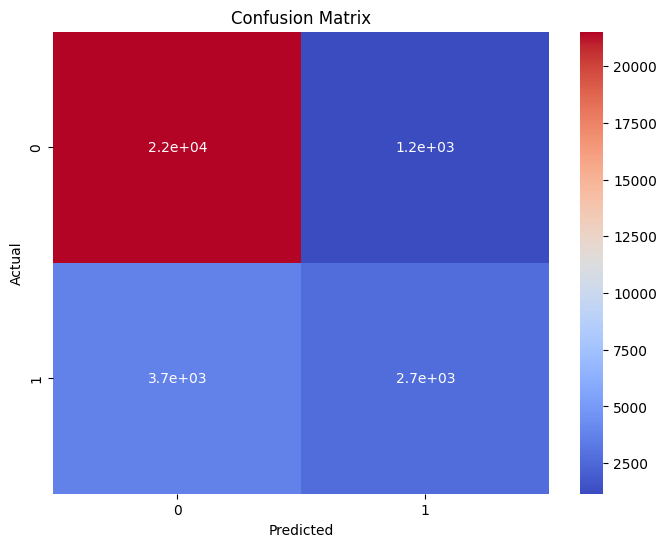

In [65]:
# Confusion Matrix - this looks for false/true positives and negatives - ranging from -1 to 1
# [[True Negative (TN) False Negative(FN)]]
# [[False Negative (FN) True Positive(TP)]]

cm = confusion_matrix(y_test, ypred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot = True, cmap ='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [66]:
# Model prediction with Precision, Recall and F1 scores
report = classification_report(y_test,ypred, target_names=['No Rain', 'Rain'])
print("Classification Report\n", report)

Classification Report
               precision    recall  f1-score   support

     No Rain       0.85      0.95      0.90     22670
        Rain       0.70      0.42      0.52      6422

    accuracy                           0.83     29092
   macro avg       0.78      0.68      0.71     29092
weighted avg       0.82      0.83      0.81     29092



**The prediction is the percentage of predicted positives that are actually positives. Recall is the percentage of actual positives that are positive. F1-score is a weighted harmonic mean of precision and recall**



# CONCLUSION:

This project provides valuable insight into prediction Rainfall for the following historical weather data.

The logistic regression model with an accuracy of 83.16%, shows potential in making reasonable decisions.

However, further analysis would be required, including exploring additional features and investigating the reasons behind false positive and false negative.

By addressing these aspects the model reliability can be improve making it more suitable for real word applications